In [1]:
import joblib
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import toml
from tqdm import tqdm
import cv2

import sys
sys.path.append('/home/lea/trampo/SMPLAnthropometry')
sys.path.append('/home/lea/trampo')

from measure import MeasureBody
from measurement_definitions import STANDARD_LABELS
from data_format.save_keypoints import save_keypoints3d

from smplx import SMPL

from multiview_consistency import computeP


In [2]:
betas_list, joints3d_list = [{}, {}, {}], [{}, {}, {}]

path = '/home/lea/trampo/4DHumans/outputs/results'
for file in os.listdir(path):
    results = joblib.load(os.path.join(path, file))
    id = int(file[5])-1

    """ for frame in results.values():
        if len(frame['tracked_ids']) >= 1:
            for t in frame['tracked_ids']:
                if t not in betas_list[id].keys():
                    betas_list[id].update({t : frame['smpl'][0]['betas']})
                else:
                    betas_list[id][t] = np.append(betas_list[id][t], frame['smpl'][0]['betas'])
                
                if t not in joints3d_list[id].keys():
                    joints3d_list[id].update({t: frame['3d_joints']})
                else:
                    joints3d_list[id][t] = np.append(joints3d_list[id][t], frame['3d_joints'])
    """

## Betas

In [3]:
joints3d_array = np.array(joints3d_list[0][1])
joints3d_array = joints3d_array.reshape(-1, 45, 3)
print(joints3d_array[0])

KeyError: 1

In [ ]:
for id, b in enumerate(betas_list):
    for t in b.keys():
        num_frames = len(b[t]) // 10
        print(id, t, num_frames)

0 1 4102
0 2 1478
0 3 2206
0 4 901
0 5 337
0 6 181
0 7 111
0 8 81
1 1 4885
1 2 851
1 4 463
1 7 143
1 3 1103
1 5 285
1 6 167
1 10 155
1 11 153
2 1 2878
2 14 726
2 2 1300


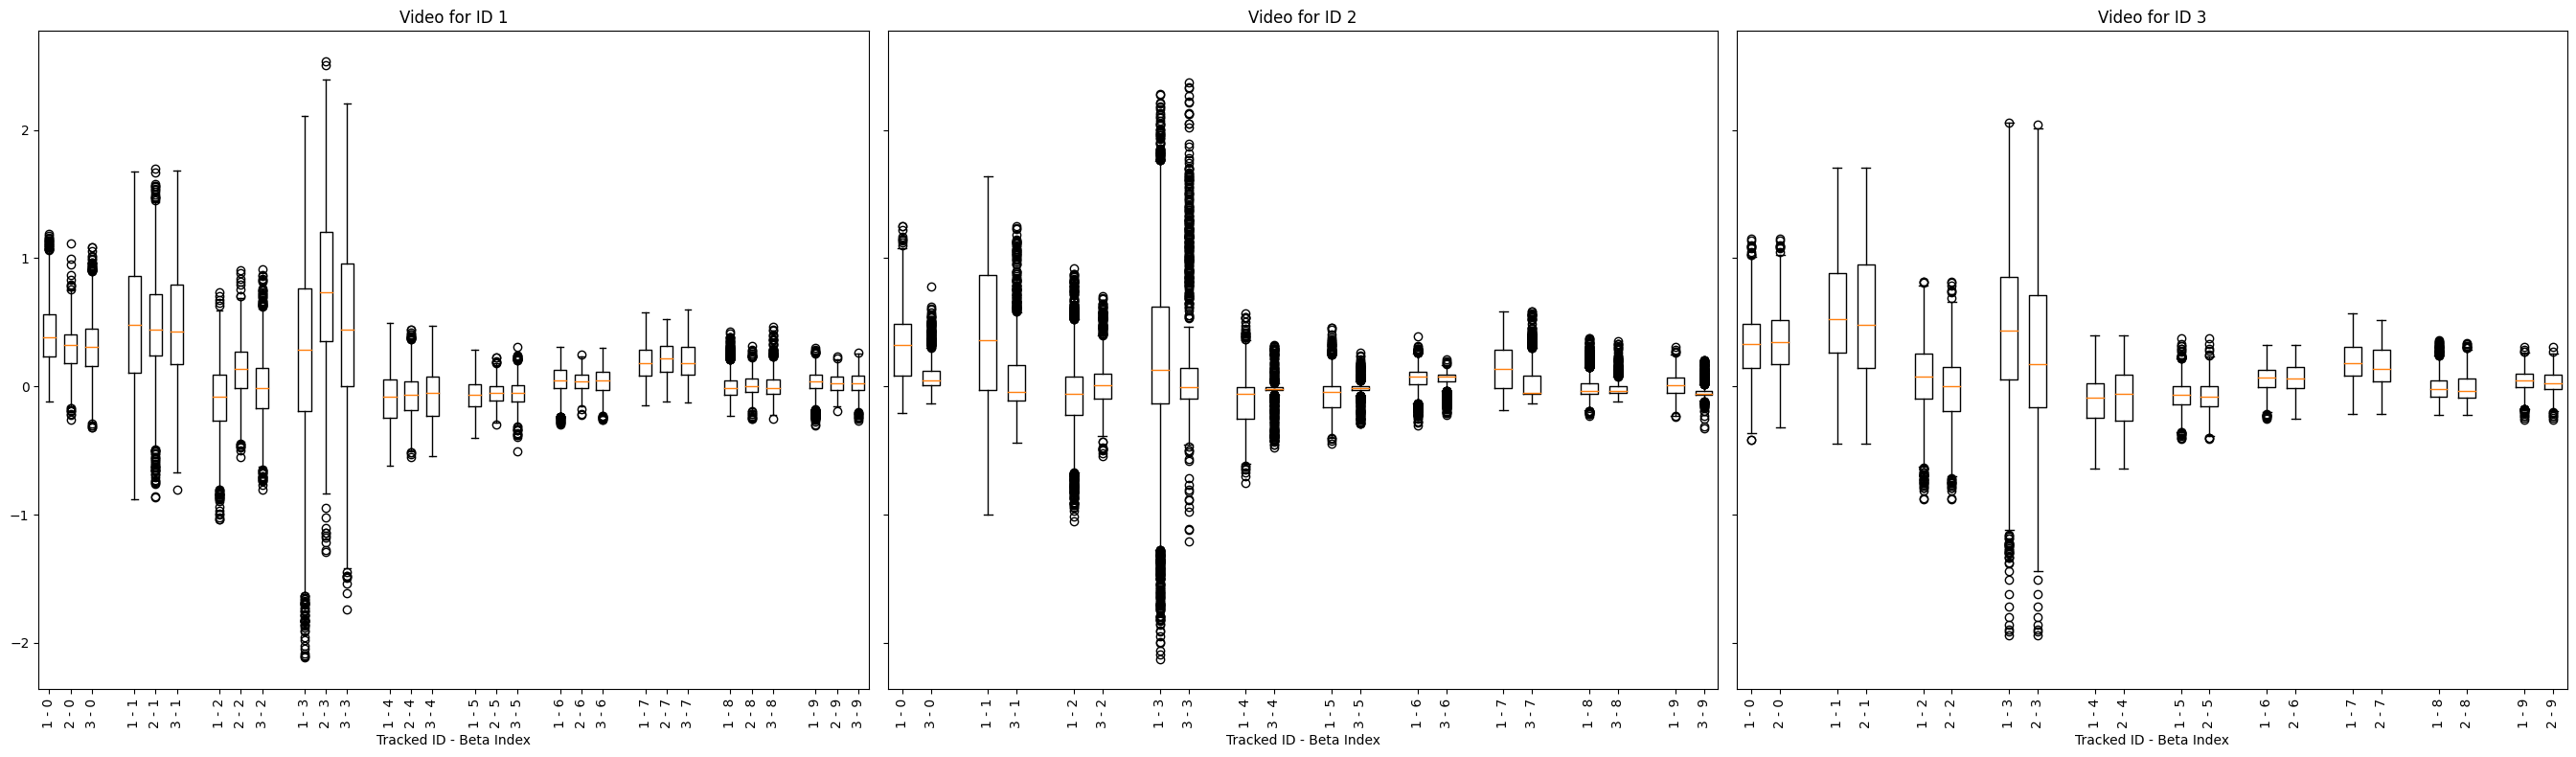

In [ ]:
min_frames = 1000  # set your desired threshold

num_ids = len(betas_list)
fig, axs = plt.subplots(1, num_ids, figsize=(9 * num_ids, 8), sharey=True)

for id in range(num_ids):
    ax = axs[id] if num_ids > 1 else axs
    beta_dict = betas_list[id]
    
    data_per_track = {}
    for t, flat_betas in beta_dict.items():
        betas = np.array(flat_betas).reshape(-1, 10)  # (N, 10)
        if betas.shape[0] >= min_frames:
            data_per_track[t] = betas

    if not data_per_track:
        ax.set_title(f"ID {id} (No tracks ≥ {min_frames} frames)")
        ax.axis('off')
        continue

    for beta_idx in range(10):
        beta_data = [data_per_track[t][:, beta_idx] for t in data_per_track]
        ax.boxplot(beta_data, 
                   positions=np.arange(len(beta_data)) + beta_idx * (len(data_per_track) + 1), 
                   widths=0.6)

    ax.set_title(f'Video for ID {id+1}')
    ax.set_xlabel('Tracked ID - Beta Index')

    xticks = []
    xticklabels = []
    for beta_idx in range(10):
        for i, t in enumerate(data_per_track.keys()):
            xticks.append(beta_idx * (len(data_per_track) + 1) + i)
            xticklabels.append(f'{t} - {beta_idx}')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=90)

plt.tight_layout()
plt.show()


SMPL to anthropo - ID 1, Track 1:  12%|█▏        | 6/50 [00:08<01:00,  1.38s/it]


KeyboardInterrupt: 

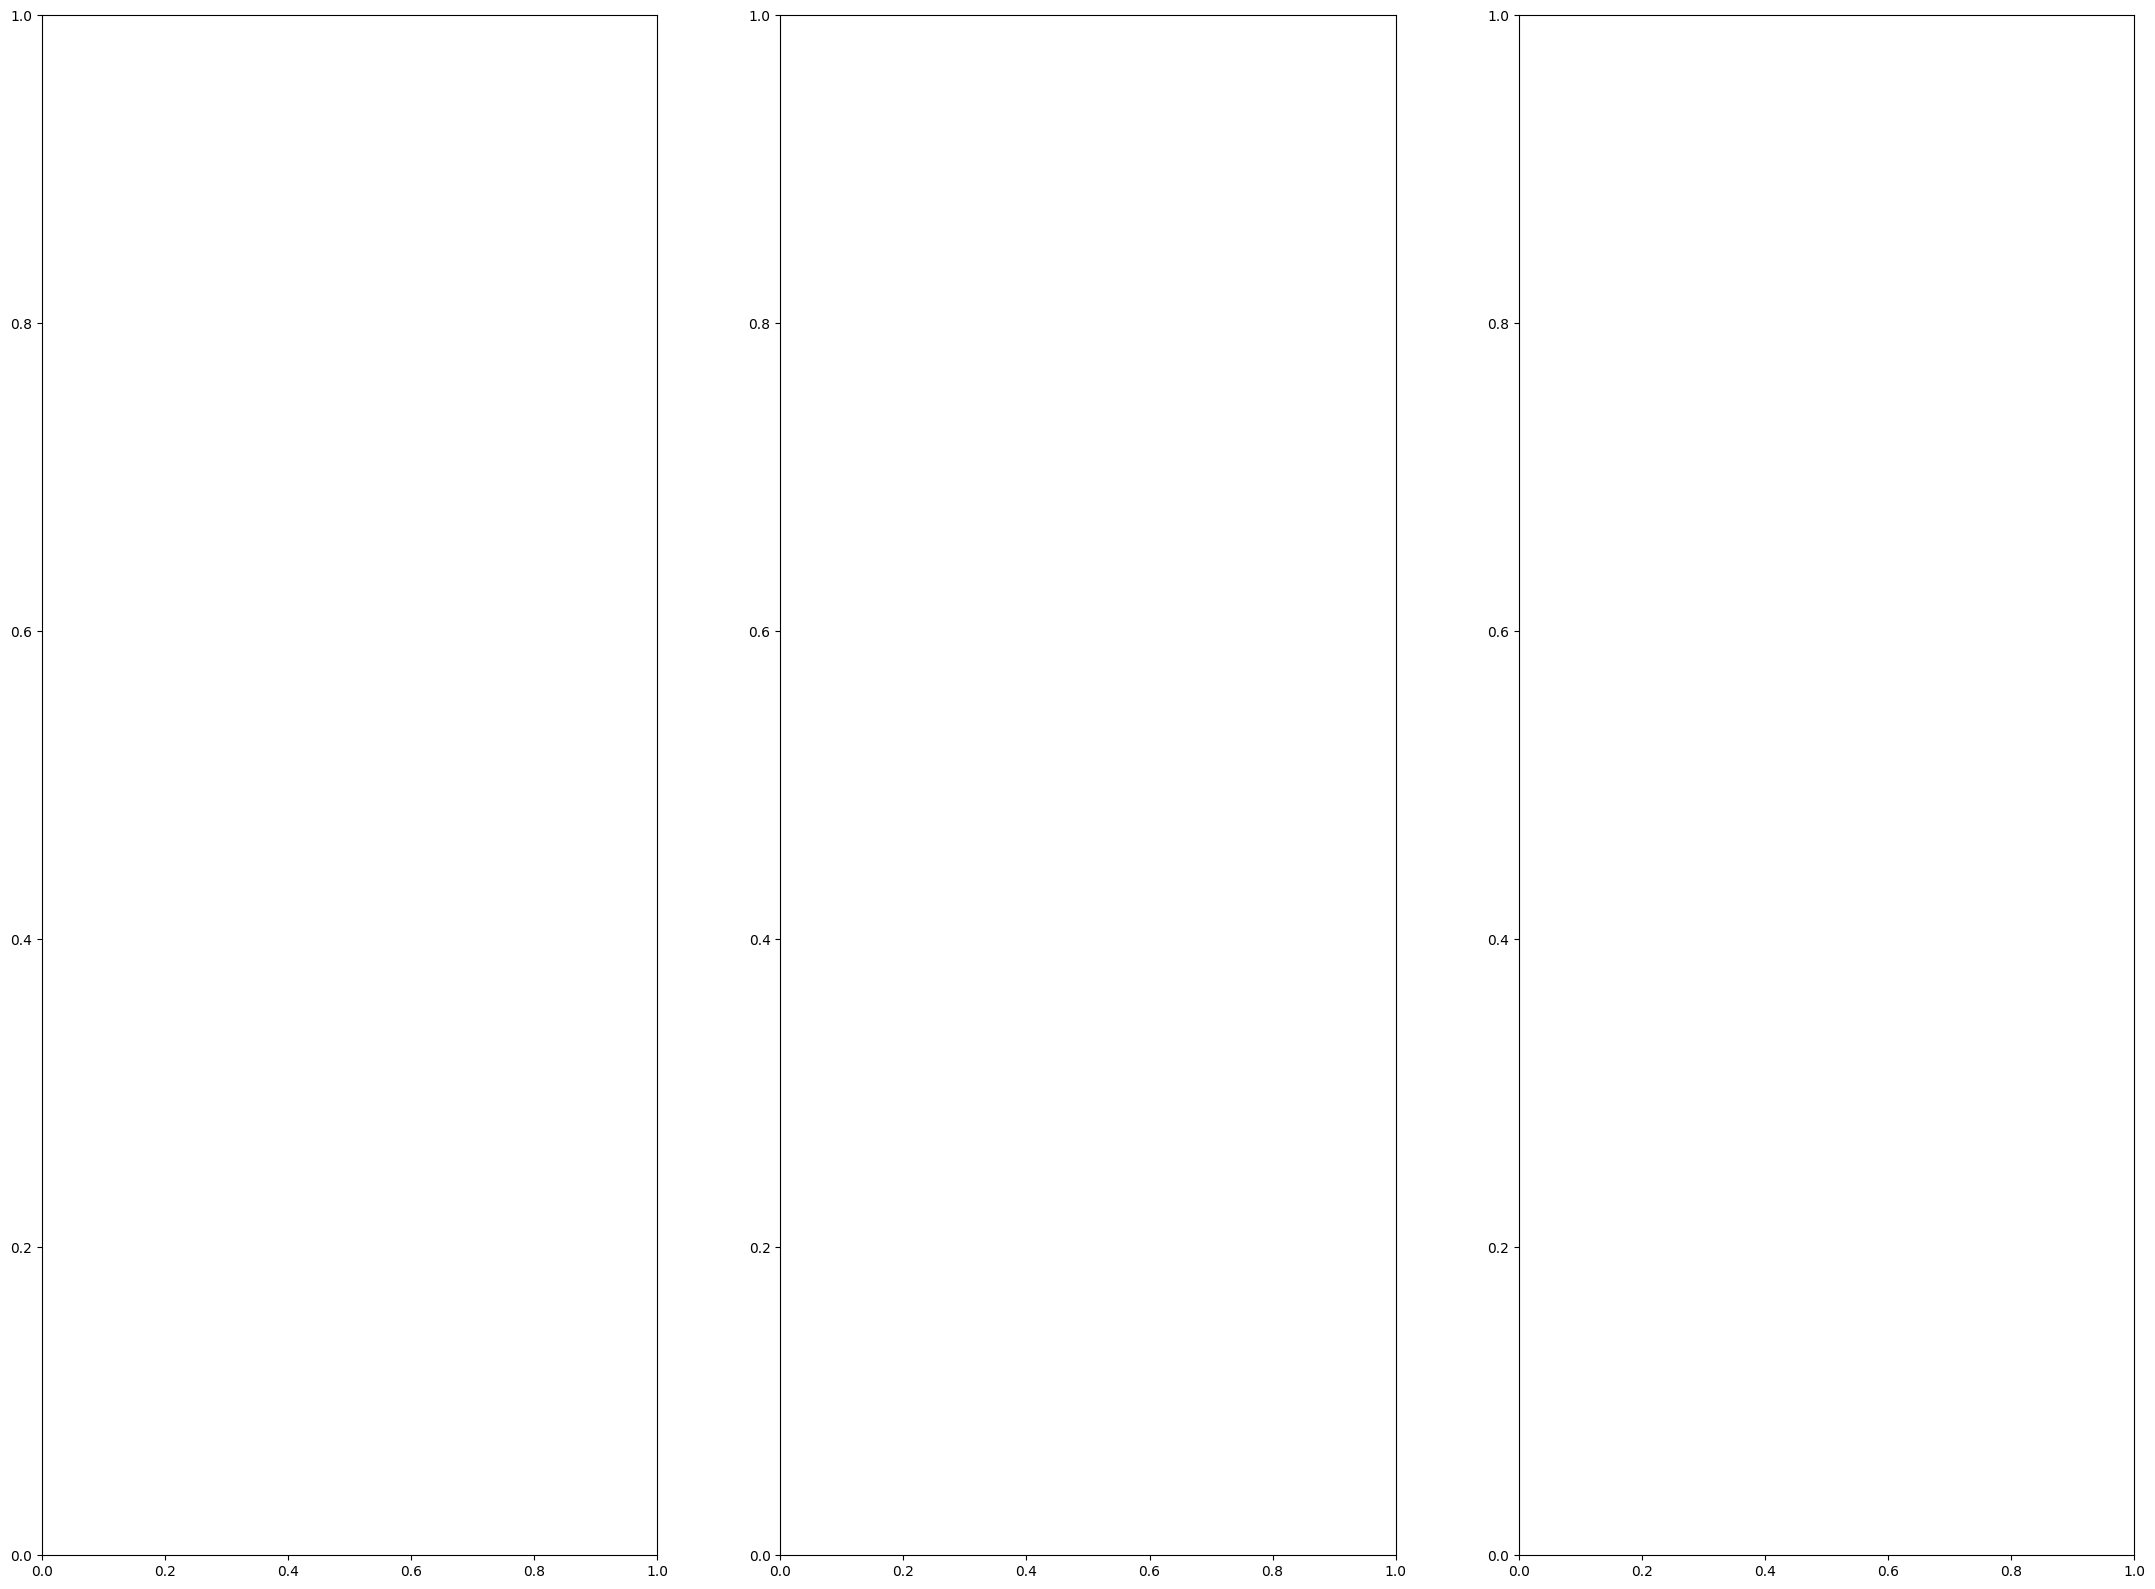

In [ ]:
min_frames = 1000  # Minimum number of frames to consider a track
num_ids = len(betas_list)
fig, axs = plt.subplots(1, num_ids, figsize=(9 * num_ids, 20))

for id in range(num_ids):
    ax = axs[id] if num_ids > 1 else axs
    beta_dict = betas_list[id]

    data_per_track = {}
    for t, flat_betas in beta_dict.items():
        betas = np.array(flat_betas).reshape(-1, 10)  # (N, 10)
        if betas.shape[0] >= min_frames:
            data_per_track[t] = betas

    if not data_per_track:
        ax.set_title(f"ID {id+1} (No tracks ≥ {min_frames} frames)")
        ax.axis('off')
        continue

    all_grouped = []
    track_labels = []

    for t_idx, (track_id, beta_data) in enumerate(data_per_track.items()):
        measurements = []
        for bd in tqdm(beta_data[:50], desc=f'SMPL to anthropo - ID {id+1}, Track {track_id}', total=50):
            bd = bd.reshape(1, 10)
            betas = torch.tensor(bd, dtype=torch.float32)

            measurer = MeasureBody('smpl')
            measurer.from_body_model(gender='neutral', shape=betas)

            measurement_names = measurer.all_possible_measurements
            measurer.measure(measurement_names)
            measurer.label_measurements(STANDARD_LABELS)

            measurements.append(measurer.measurements)

        # Group by measurement name
        grouped = {k: [d[k] for d in measurements] for k in measurements[0]}
        all_grouped.extend(grouped.values())
        track_labels.extend([f'{track_id} - {k}' for k in grouped.keys()])

    ax.boxplot(all_grouped)
    ax.set_title(f'Video for ID {id+1}')
    ax.set_xlabel('Measurement Type per Track')
    ax.set_xticks(range(1, len(track_labels) + 1))
    ax.set_xticklabels(track_labels, rotation=90)

ax.set_ylabel('Measurement Value')
plt.tight_layout()
plt.show()


### Même chose qu'avant mais on merge tous les tracked ids qui sont présents dans plus de N frams (après analyse visuelle, seul l'athlète est détecté mais mal tracké)

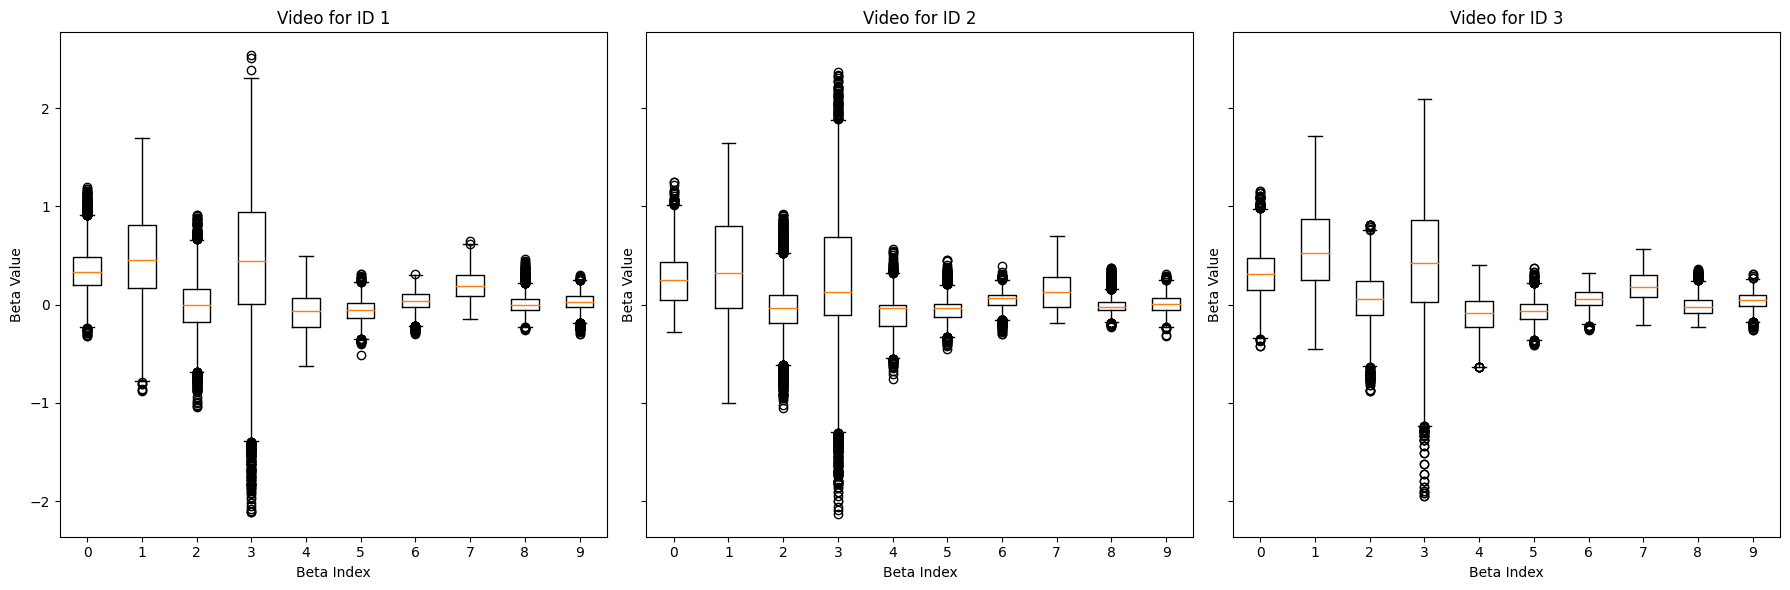

In [ ]:
min_frames = 120  # or whatever threshold you choose
merged_betas_list = []

for id in range(len(betas_list)):
    beta_dict = betas_list[id]
    merged_betas = []

    for t, flat_betas in beta_dict.items():
        betas = np.array(flat_betas).reshape(-1, 10)
        if betas.shape[0] >= min_frames:
            merged_betas.append(betas)

    if merged_betas:
        merged_betas = np.vstack(merged_betas)  # shape (N_total, 10)
    else:
        merged_betas = np.empty((0, 10))
        
    merged_betas_list.append(merged_betas)


fig, axs = plt.subplots(1, len(merged_betas_list), figsize=(6 * len(merged_betas_list), 6), sharey=True)

for id in range(len(merged_betas_list)):
    ax = axs[id] if len(merged_betas_list) > 1 else axs
    betas = merged_betas_list[id]

    if betas.shape[0] == 0:
        ax.set_title(f"ID {id} (No tracks ≥ {min_frames} frames)")
        ax.axis('off')
        continue

    # Prepare beta-wise data
    beta_data = [betas[:, i] for i in range(10)]
    ax.boxplot(beta_data, labels=[f'{i}' for i in range(10)])
    ax.set_title(f"Video for ID {id+1}")
    ax.set_xlabel('Beta Index')
    ax.set_ylabel('Beta Value')

plt.tight_layout()
plt.show()


### SMPL-Anthropometry avec tracked ids merged, sur tous les frames

(9205, 10)


SMPL to anthropo - ID 1: 100%|██████████| 1841/1841 [40:57<00:00,  1.34s/it]


(8205, 10)


SMPL to anthropo - ID 2: 100%|██████████| 1641/1641 [36:24<00:00,  1.33s/it]


(4904, 10)


SMPL to anthropo - ID 3: 100%|██████████| 981/981 [21:55<00:00,  1.34s/it]


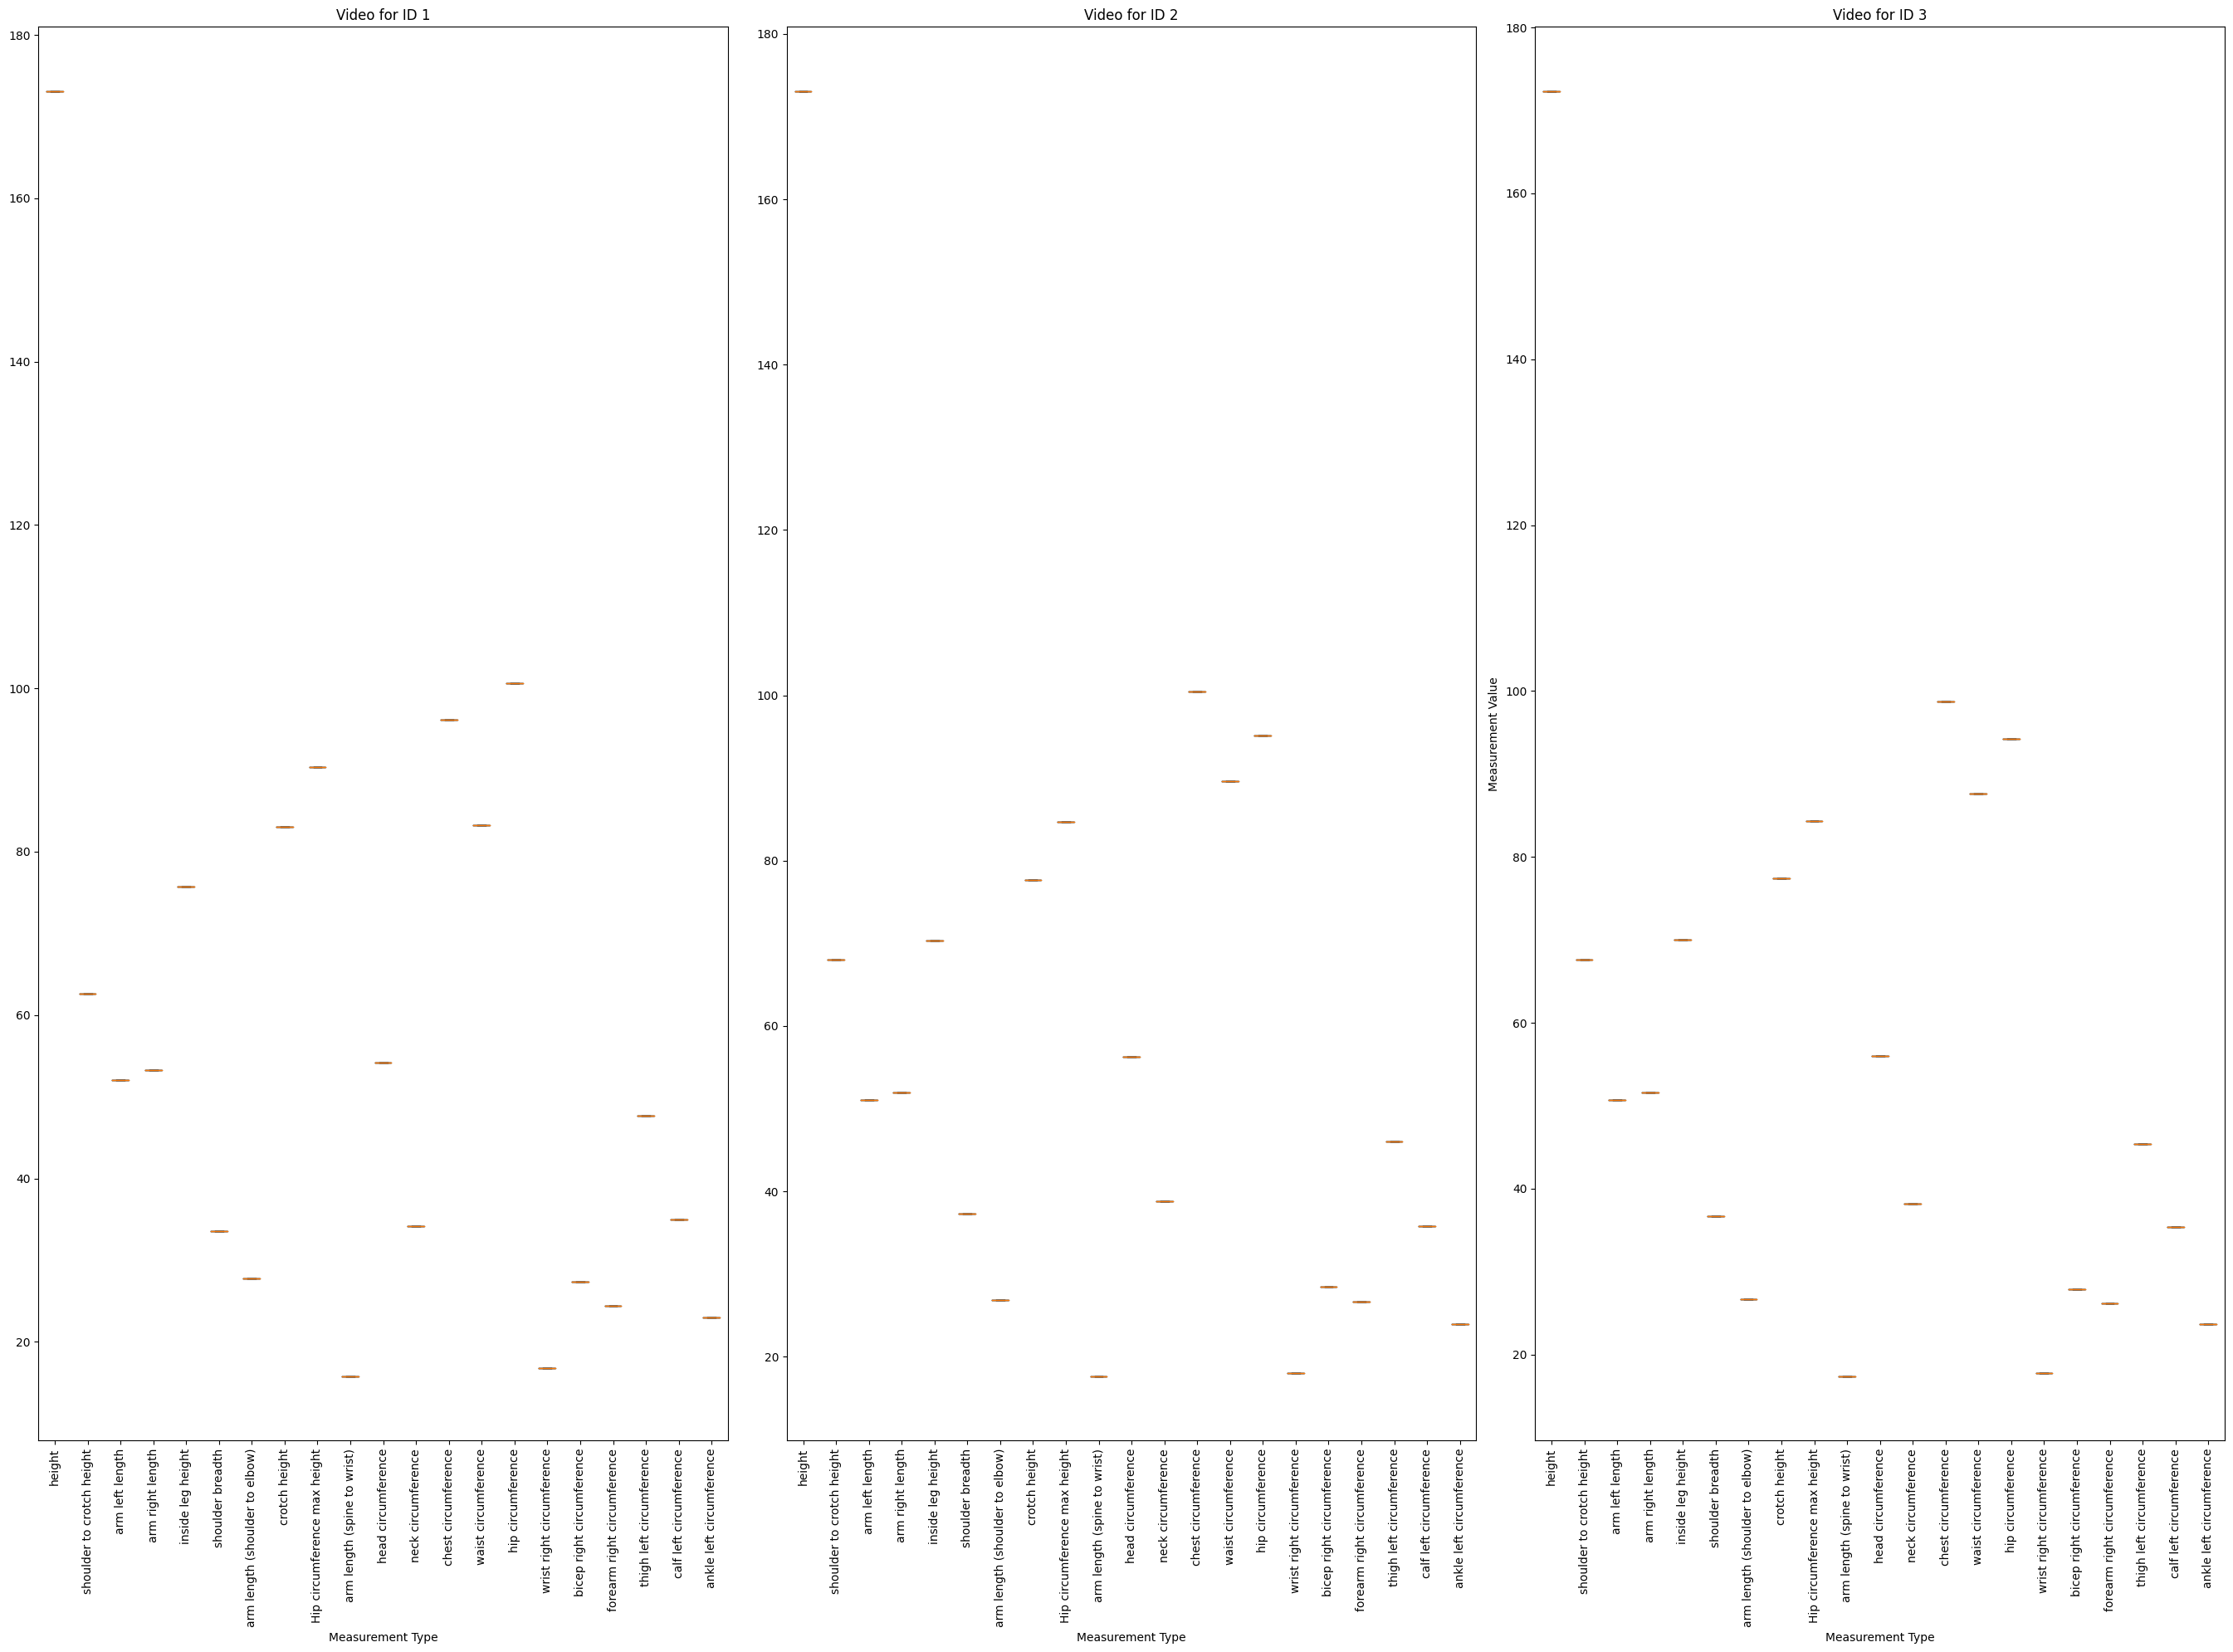

In [ ]:
num_ids = len(betas_list)
fig, axs = plt.subplots(1, num_ids, figsize=(9 * num_ids, 20))

for id in range(num_ids):
    ax = axs[id] if num_ids > 1 else axs
    beta_dict = betas_list[id]

    # Filter and merge all valid tracks for this ID
    merged_betas = []
    for t, flat_betas in beta_dict.items():
        betas = np.array(flat_betas).reshape(-1, 10)  # (N, 10)
        if betas.shape[0] >= min_frames:
            merged_betas.append(betas)

    if not merged_betas:
        ax.set_title(f"ID {id+1} (No tracks ≥ {min_frames} frames)")
        ax.axis('off')
        continue

    merged_betas = np.vstack(merged_betas)  # Combine into one array
    print(merged_betas.shape)
    measurements = []

    # Use only first 50 frames for measurement conversion (or adjust as needed)
    for bd in tqdm(range(0, len(merged_betas), 5), desc=f'SMPL to anthropo - ID {id+1}'):
        bd = merged_betas[i].reshape(1, 10)
        betas = torch.tensor(bd, dtype=torch.float32)

        measurer = MeasureBody('smpl')
        measurer.from_body_model(gender='neutral', shape=betas)

        measurement_names = measurer.all_possible_measurements
        measurer.measure(measurement_names)
        measurer.label_measurements(STANDARD_LABELS)

        measurements.append(measurer.measurements)

    # Group by measurement name
    grouped = {k: [d[k] for d in measurements] for k in measurements[0]}
    all_grouped = list(grouped.values())
    track_labels = list(grouped.keys())

    ax.boxplot(all_grouped)
    ax.set_title(f'Video for ID {id+1}')
    ax.set_xlabel('Measurement Type')
    ax.set_xticks(range(1, len(track_labels) + 1))
    ax.set_xticklabels(track_labels, rotation=90)

ax.set_ylabel('Measurement Value')
plt.tight_layout()
plt.show()

## Retrieve and save keypoints from SMPL output

In [2]:
def rotation_matrix_to_angle_axis(rotation_matrix):
    """
    Convert a batch of rotation matrices (N, 3, 3) to axis-angle (N, 3).
    """
    def _angle_axis_from_rotmat(R):
        cos_theta = (torch.diagonal(R, dim1=-2, dim2=-1).sum(-1) - 1) / 2
        cos_theta = torch.clamp(cos_theta, -1.0, 1.0)
        theta = torch.acos(cos_theta)

        rx = R[..., 2, 1] - R[..., 1, 2]
        ry = R[..., 0, 2] - R[..., 2, 0]
        rz = R[..., 1, 0] - R[..., 0, 1]
        axis = torch.stack([rx, ry, rz], dim=-1)

        axis = axis / (2 * torch.sin(theta).unsqueeze(-1) + 1e-8)
        axis_angle = axis * theta.unsqueeze(-1)

        axis_angle[torch.isnan(axis_angle)] = 0.0
        return axis_angle

    return _angle_axis_from_rotmat(rotation_matrix)

### Save SMPL 3D keypoints

In [ ]:
model = SMPL(model_path='/home/lea/trampo/SMPLAnthropometry/data/smpl', gender='neutral', batch_size=1)

J_regressor = np.load('/home/lea/trampo/SMPLAnthropometry/J_regressor_coco.npy')  # shape: (17, 6890)
J_regressor = torch.tensor(J_regressor, dtype=torch.float32)

path = '/home/lea/trampo/4DHumans/outputs/results'
print(os.listdir(path))

for file in sorted(os.listdir(path)):
    all_keypoints = {}
    keypoint_pkl_path = None

    results = joblib.load(os.path.join(path, file))

    # Output setup
    json_output_dir = os.path.join('SMPL_keypoints', file.replace('demo_', '').split('.')[0] + '_json')
    pkl_output_dir = 'SMPL_keypoints'

    # Loop on all frames
    for frame in results: #['outputs//_DEMO/1_partie_0429-Camera1_M11139/img/000032.jpg']
        frame_res = results[frame]
        if len(frame_res['smpl']) == 0:
            continue

        keypoints = []
        keypoints_per_frame = []
        # Loop on detected ids
        for i, output in enumerate(frame_res['smpl']):
            try:
                id = frame_res['tracked_ids'][i]
            except IndexError:
                id = -1
            
            # Keypoints from SMPL
            your_10_betas = output['betas']
            betas_np = np.array(your_10_betas)

            your_global_orient = output['global_orient']
            your_body_pose = output['body_pose']
            your_transl = frame_res['pose'][i][-3:]

            body_pose_rotmats = torch.tensor(your_body_pose, dtype=torch.float32)  # ensure it's tensor
            # Convert (23, 3, 3) → (23, 3)
            body_pose_aa = rotation_matrix_to_angle_axis(body_pose_rotmats)

            # Handle potential NaNs due to numerical instability
            body_pose_aa[torch.isnan(body_pose_aa)] = 0.0
            body_pose_final = body_pose_aa.reshape(1, 69)

            global_orient_aa = rotation_matrix_to_angle_axis(torch.tensor(your_global_orient))  # (1, 3, 3) → (1, 3)
            #global_orient_aa = global_orient_aa.view(1, 3)

            betas = torch.tensor([betas_np], dtype=torch.float32)
            body_pose = torch.tensor([your_body_pose], dtype=torch.float32)
            global_orient = torch.tensor([your_global_orient], dtype=torch.float32)
            transl = torch.tensor([your_transl], dtype=torch.float32)

            output = model(
                betas=betas,                      # (1, 10)
                body_pose=body_pose_final,        # (1, 69)
                global_orient=global_orient_aa,   # (1, 3)
                transl=transl,
                return_verts=True)

            vertices = output.vertices  # (1, 6890, 3)

            keypoints_coco = torch.matmul(J_regressor, vertices[0])  # shape: (17, 3)
            keypoints_arr = keypoints_coco.detach().numpy()

            #print('SMPL', keypoints_arr, '\n')

            # Keypoints from Joints3D
            keypoints_3d = np.array(frame_res['3d_joints'][i])  # (49, 3)

            #print('Joints', keypoints_3d, '\n')
        
            keypoints.append((i, keypoints_3d.reshape(45,3)))

            keypoints_per_frame.append({"id": id,
                                        "keypoints": keypoints_3d.reshape(45,3).tolist()})

        image_file = frame.split('/')[-3]
        frame_idx = frame.split('/')[-1].split('.')[0]

        all_keypoints[frame_idx] = keypoints_per_frame

        json_file_path = os.path.join(json_output_dir, f"{os.path.splitext(os.path.basename(image_file))[0]}_{frame_idx}.json")
        keypoint_pkl_path = os.path.join(pkl_output_dir, f"{os.path.splitext(os.path.basename(image_file))[0]}.pkl")

        save_keypoints3d(json_file_path, keypoints)

    # Save all keypoints as .pkl
    if not os.path.isdir(pkl_output_dir): os.makedirs(pkl_output_dir)
    if keypoint_pkl_path is not None:
        with open(keypoint_pkl_path, 'wb') as f:
            pickle.dump(all_keypoints, f)

['demo_2_partie_0429-Camera7_M11462.pkl', 'demo_3_partie_0429_001-Camera2_M11140.pkl', 'demo_2_partie_0429_000-Camera4_M11458.pkl', 'demo_2_partie_0429-Camera6_M11461.pkl', 'demo_2_partie_0429-Camera2_M11140.pkl', 'demo_2_partie_0429_000-Camera6_M11461.pkl', 'demo_3_partie_0429_001-Camera3_M11141.pkl', 'demo_2_partie_0429_000-Camera3_M11141.pkl', 'demo_2_partie_0429_000-Camera7_M11462.pkl', 'demo_1_partie_0429-Camera6_M11461.pkl', 'demo_2_partie_0429_000-Camera5_M11459.pkl', 'demo_2_partie_0429-Camera4_M11458.pkl', 'demo_2_partie_0429_000-Camera2_M11140.pkl', 'demo_2_partie_0429-Camera8_M11463.pkl', 'demo_1_partie_0429-Camera3_M11141.pkl', 'demo_1_partie_0429-Camera7_M11462.pkl', 'demo_1_partie_0429-Camera8_M11463.pkl', 'demo_1_partie_0429-Camera5_M11459.pkl', 'demo_2_partie_0429_000-Camera1_M11139.pkl', 'demo_2_partie_0429-Camera3_M11141.pkl', 'demo_2_partie_0429-Camera5_M11459.pkl', 'demo_3_partie_0429_001-Camera1_M11139.pkl', 'demo_1_partie_0429-Camera4_M11458.pkl', 'demo_2_partie_0

/tmp/ipykernel_134610/2819744341.py:80: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  betas = torch.tensor([betas_np], dtype=torch.float32)


KeyboardInterrupt: 

### Save 2D joints

In [222]:
def project(joints_3d, cam_trans, size, scale=1):
    f = 5000

    K = np.array([[f/256, 0, 0],
                [0, f/256, 0],
                [0, 0, 1]])
    R = np.eye(3)

    points = joints_3d + cam_trans # (4,3)

    proj = (K @ R @ points.T).T # (4,3)
    proj_norm = proj[:,:2] / proj[:,2].reshape(-1,1)
    proj_im = proj_norm * max(size) * scale
    proj_im += np.array(size[::-1])/2
    return proj_im

In [224]:
path = '/home/lea/trampo/4DHumans/outputs/results'
print(os.listdir(path))

for file in sorted(os.listdir(path)):
    all_keypoints = {}
    keypoint_pkl_path = None

    results = joblib.load(os.path.join(path, file))

    # Output setup
    json_output_dir = os.path.join('SMPL_keypoints', file.replace('demo_', '').split('.')[0] + '_json')
    pkl_output_dir = 'SMPL_keypoints'

    # Loop on all frames
    for frame in results: #['outputs//_DEMO/1_partie_0429-Camera1_M11139/img/000032.jpg']
        frame_res = results[frame]
        if len(frame_res['smpl']) == 0:
            continue

        keypoints = []
        keypoints_per_frame = []
        # Loop on detected ids
        for i, output in enumerate(frame_res['smpl']):
            try:
                id = frame_res['tracked_ids'][i]
            except IndexError:
                id = -1
            
            bbox = frame_res['bbox'][i]
            conf = frame_res['conf'][i]
            conf = np.ones((45,1)) * conf

            size = frame_res['size'][i]
            cam_trans = frame_res['camera'][i]

            joints_3d = frame_res['3d_joints'][i]
            pts2d = project(joints_3d, cam_trans, size)

            keypoints = np.hstack((pts2d, conf))

            keypoints_per_frame.append({"id": id,
                                        "bbox": bbox,
                                        "keypoints": keypoints})

        image_file = frame.split('/')[-3]
        frame_idx = frame.split('/')[-1].split('.')[0]

        all_keypoints[frame_idx] = keypoints_per_frame

        json_file_path = os.path.join(json_output_dir, f"{os.path.splitext(os.path.basename(image_file))[0]}_{frame_idx}.json")
        keypoint_pkl_path = os.path.join(pkl_output_dir, f"{os.path.splitext(os.path.basename(image_file))[0]}.pkl")

    # Save all keypoints as .pkl
    if not os.path.isdir(pkl_output_dir): os.makedirs(pkl_output_dir)
    if keypoint_pkl_path is not None:
        with open(keypoint_pkl_path, 'wb') as f:
            pickle.dump(all_keypoints, f)

['demo_2_partie_0429-Camera7_M11462.pkl', 'demo_3_partie_0429_001-Camera2_M11140.pkl', 'demo_2_partie_0429_000-Camera4_M11458.pkl', 'demo_2_partie_0429-Camera6_M11461.pkl', 'demo_2_partie_0429-Camera2_M11140.pkl', 'demo_2_partie_0429_000-Camera6_M11461.pkl', 'demo_3_partie_0429_001-Camera3_M11141.pkl', 'demo_2_partie_0429_000-Camera3_M11141.pkl', 'demo_2_partie_0429_000-Camera7_M11462.pkl', 'demo_1_partie_0429-Camera6_M11461.pkl', 'demo_2_partie_0429_000-Camera5_M11459.pkl', 'demo_2_partie_0429-Camera4_M11458.pkl', 'demo_2_partie_0429_000-Camera2_M11140.pkl', 'demo_2_partie_0429-Camera8_M11463.pkl', 'demo_1_partie_0429-Camera3_M11141.pkl', 'demo_1_partie_0429-Camera7_M11462.pkl', 'demo_1_partie_0429-Camera8_M11463.pkl', 'demo_1_partie_0429-Camera5_M11459.pkl', 'demo_2_partie_0429_000-Camera1_M11139.pkl', 'demo_2_partie_0429-Camera3_M11141.pkl', 'demo_2_partie_0429-Camera5_M11459.pkl', 'demo_3_partie_0429_001-Camera1_M11139.pkl', 'demo_1_partie_0429-Camera4_M11458.pkl', 'demo_2_partie_0

[0.7822 0.2023 0.2197] [  1.7948   0.2657 152.9172]
[1.1608 0.093  0.0199] [  0.0028  -0.1603 166.9065]
[ 0.8417 -0.0792  0.3489] [ -2.4937  -0.3552 153.0454]


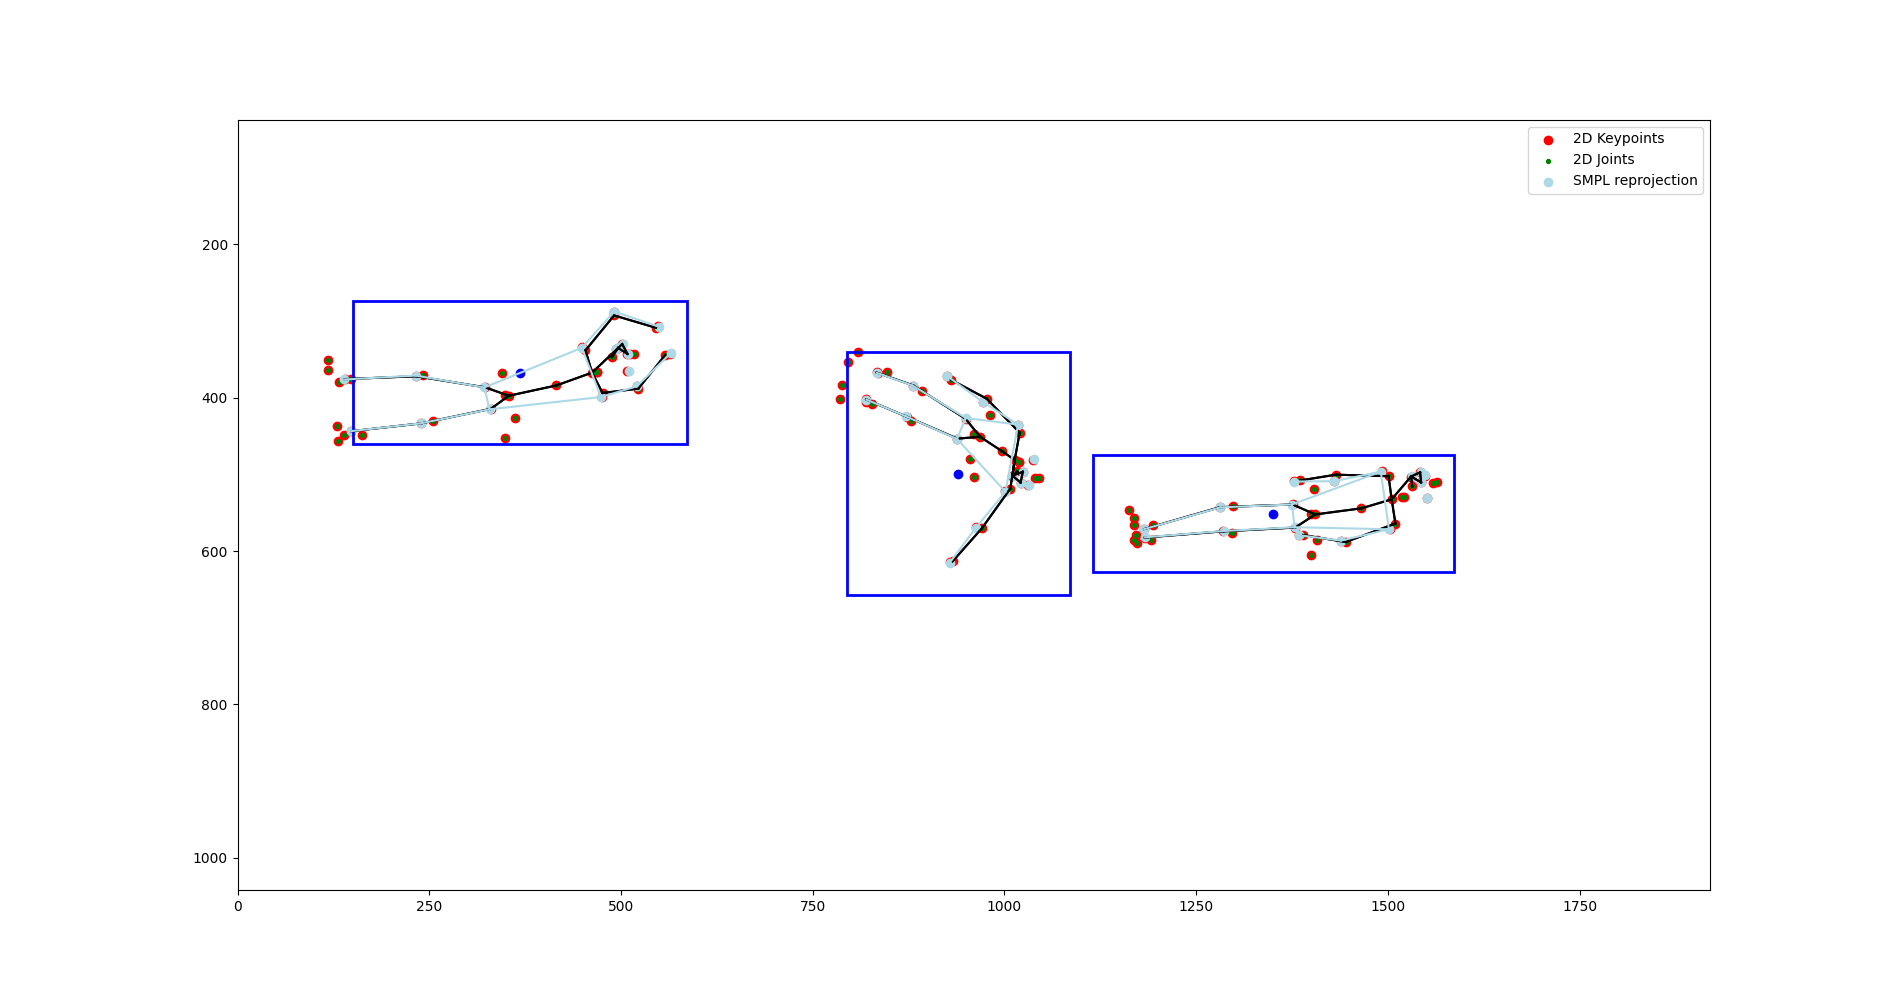

In [ ]:
P_all, Kh = computeP('/home/lea/trampo/Pose2Sim/Calibration/Calib.toml')

model = SMPL(model_path='/home/lea/trampo/SMPLAnthropometry/data/smpl', gender='neutral', batch_size=1)

J_regressor = np.load('/home/lea/trampo/SMPLAnthropometry/J_regressor_coco.npy')  # shape: (17, 6890)
J_regressor = torch.tensor(J_regressor, dtype=torch.float32)

def draw_skeleton(points_2d, color, ax, label=None, N=45):
    if N == 45:
        skeleton = [
            (16, 15),
            (0, 15),
            (0, 16),
            (0, 42),
            (0, 40),
            (40, 41),
            (41, 39),
            (40, 33),
            (33, 32),
            (32, 31),
            (40, 34),
            (34, 35),
            (35, 36),
            (39, 9),
            (9, 10),
            (10, 11),
            (39, 12),
            (12, 13),
            (13, 14)]
    elif N == 17:
        skeleton = [
            (5, 6),  # épaule gauche - coude gauche
            (5, 7),  # coude gauche - poignet gauche
            (7, 9),
            (6, 8),  # épaule droite - coude droit
            (8, 10), # coude droit - poignet droit
            (6, 12), # épaule gauche - hanche gauche
            (12, 14),# hanche gauche - hanche droite
            (14, 16),# hanche gauche - genou gauche
            (5, 11),
            (11, 13),# genou gauche - cheville gauche
            (13, 15),# hanche droite - genou droit
            (11, 12)]

    for i, j in skeleton:
        xline = [points_2d[i][0], points_2d[j][0]]
        yline = [points_2d[i][1], points_2d[j][1]]
        ax.plot(xline, yline, color=color)
    return

def extract_keypoints_smpl(frame_res, i, model, J_regressor):
    output = frame_res['smpl'][i]
    your_10_betas = output['betas']
    betas_np = np.array(your_10_betas)
    betas = torch.tensor([betas_np], dtype=torch.float32)

    your_global_orient = output['global_orient']
    global_orient_aa = rotation_matrix_to_angle_axis(torch.tensor(your_global_orient))  # (1, 3, 3) → (1, 3)

    your_body_pose = output['body_pose']
    body_pose_np = np.array(your_body_pose)
    body_pose_rotmats = torch.tensor(body_pose_np, dtype=torch.float32)  # ensure it's tensor
    # Convert (23, 3, 3) → (23, 3)
    body_pose_aa = rotation_matrix_to_angle_axis(body_pose_rotmats)

    # Handle potential NaNs due to numerical instability
    body_pose_aa[torch.isnan(body_pose_aa)] = 0.0
    body_pose_final = body_pose_aa.reshape(1, 69)
    
    your_transl = frame_res['pose'][i][-3:]
    transl = torch.tensor([your_transl], dtype=torch.float32)

    output = model(
        betas=betas,                      # (1, 10)
        body_pose=body_pose_final,        # (1, 69)
        global_orient=global_orient_aa,   # (1, 3)
        return_verts=True)

    vertices = output.vertices  # (1, 6890, 3)

    keypoints_coco = torch.matmul(J_regressor, vertices[0])  # shape: (17, 3)
    keypoints_arr = keypoints_coco.detach().numpy()

    return keypoints_arr

cam_idx = 6
cameras = ['M11139', 'M11140', 'M11141', 'M11458', 'M11459', 'M11461', 'M11462', 'M11463']

filepath = f'/home/lea/trampo/4DHumans/outputs/results/demo_1_partie_0429-Camera{cam_idx+1}_{cameras[cam_idx]}.pkl'
P = P_all[cam_idx]
K = Kh[cam_idx]
results = joblib.load(filepath)

# Plot
fig, ax = plt.subplots(figsize=(19,10))

# Loop on all frames
for frame in results: #['outputs//_DEMO/1_partie_0429-Camera1_M11139/img/000032.jpg']
    
    frame_res = results[frame]
    frame_idx = int(frame_res['time'])

    # Loop on detected ids
    for i, id in enumerate(frame_res['tracked_ids']):
        #print('id:', id)
        size = frame_res['size'][i]
        scale = frame_res['scale'][i]
        cam_trans = frame_res['camera'][i]
        center = frame_res['center'][i]
        bbox = frame_res['bbox'][i]
        xmin, ymin, width, height = bbox
        #print('BBOX:', bbox)

        # Keypoints from SMPL
        smpl_keypoints = extract_keypoints_smpl(frame_res, i, model, J_regressor)
        #smpl_keypoints = smpl_keypoints[:, [0,1,2]]
        transl = frame_res['camera_bbox'][i]
        smpl_proj = project(smpl_keypoints, cam_trans, size)

        #print(smpl_proj)

        # 3D Joints projected
        joints_3d = frame_res['3d_joints'][i]
        pts2d = project(joints_3d, cam_trans, size)
        #print('Projected points')
        #print(pts2d)

        # 2D Joints
        joints_2d = frame_res['2d_joints'][i]
        joints_2d = np.array(joints_2d).reshape((45,2))

        joints_2d *= max(size)
        joints_2d = joints_2d - (0, 420)

        #print('Detected 2d points')
        #print(joints_2d)

        # Show points and bounding box
        if frame_idx % 500 == 0:
            print(transl, cam_trans)
            # Add keypoints and bbox to plot
            ax.scatter(pts2d[:, 0], pts2d[:, 1], color='red', label='2D Keypoints')
            #for kp, pt in enumerate(pts2d):
            #    ax.text(pt[0], pt[1], kp, fontsize=6)
            draw_skeleton(pts2d, 'black', ax)
            ax.scatter(joints_2d[:,0], joints_2d[:,1], color='green', s=8, label='2D Joints')
            draw_skeleton(joints_2d, 'black', ax)
            ax.scatter(center[0], center[1], color='blue')
            ax.scatter(smpl_proj[:,0], smpl_proj[:,1], color='lightblue', label='SMPL reprojection')
            draw_skeleton(smpl_proj, 'lightblue', ax, N=17)
            bbox = plt.Rectangle((xmin, ymin), width, height,
                                linewidth=2, edgecolor='blue', facecolor='none')
            ax.add_patch(bbox)
            
        #break

ax.axis('equal')
ax.set_xlim(0,1920)
ax.set_ylim(0,1080)
ax.invert_yaxis()
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())
plt.show()
